In [1]:
from func import *

In [2]:
def read_ras(file_path, file_type=None, is_label=False):
    _, _, img = file_reader(file_path, file_type)
    print("header", img.header)
    img_ras = do_nibabel_transform_to_ras(img)
    if is_label:
        file_labels = list(FILE_TO_LABEL_MAP.keys())
        lidx, labelname = fetch_class_labels_from_filemap(file_path, file_labels)
        return img_ras, lidx, labelname
    else:
        return img_ras

In [28]:

def label_stitching(label_parts, img_reference):
    header = img_reference.header
    target_affine = img_reference.affine
    target_header = img_reference.header
    steps = header['pixdim'][1:4]
    volume = img_reference.get_fdata()
    im_dim_v = volume.shape

    processed_segm = None  # np.zeros((500,500,1000))

    im_offx = abs(header['qoffset_x'])
    im_offy = abs(header['qoffset_y'])
    im_offz = abs(header['qoffset_z'])
    q_offsets = [im_offx, im_offy, im_offz]

    reference_labelmap = None
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)

        if reference_labelmap is None:
            reference_labelmap = labelmap_img
        else:
            mode = 'nearest'
            labelmap_img = resample_from_to(labelmap_img, [reference_labelmap.shape, reference_labelmap.affine],
                                            mode=mode)
            print('c shape:', labelmap_img.shape, labelmap_img.affine)

        label_header = labelmap_img.header
        labelmap = labelmap_img.get_fdata()
        labelmap_affine = labelmap_img.affine
        steps_l = label_header['pixdim'][1:4]
        lblmp_offx = abs(label_header['qoffset_x'])
        lblmp_offy = abs(label_header['qoffset_y'])
        lblmp_offz = abs(label_header['qoffset_z'])
        q_offsets_l = [lblmp_offx, lblmp_offy, lblmp_offz]
        print("label header:", label_header)
        print(f'vol offsets: {q_offsets}')

        print(f'label_offsets: {q_offsets_l}')

        #         l_vol = np.prod(labelmap.shape)
        segm_dim_v = labelmap.shape

        ############
        labelmap2vol = npl.inv(target_affine).dot(labelmap_affine)
        seg_start_inv = np.floor(apply_affine(labelmap2vol, [0, 0, 0])).astype(np.int32)
        seg_end_inv = apply_affine(labelmap2vol, segm_dim_v).astype(np.int32)
        print(labelmap2vol, "seg start inv v: ", seg_start_inv, "segm end inv v:", seg_end_inv)
        ############
        shifts = tuple(np.floor(labelmap2vol[:3, 3]).astype(np.int32))
        seg_intermediate = np.floor(apply_affine(labelmap2vol, [1, 1, 1])).astype(np.int32)
        print(seg_start_inv, "seg intermediate:", seg_intermediate)
        flipornot = np.sign(seg_intermediate - seg_start_inv)
        print("flipornot:", flipornot)
        ax = 0
        for shift, inverse_code in zip(seg_start_inv, flipornot):
            print(ax, shift, inverse_code)
            shift = int(shift)
            if True:
                if inverse_code < 0:
                    labelmap = flip_axis(labelmap, axis=ax)
                if shift < 0:
                    #                     labelmap = flip_axis(labelmap, axis=ax) #if ax == 1 else labelmap
                    seg_end_inv[ax] += abs(seg_start_inv[ax])
                    seg_start_inv[ax] = 0
                else:
                    #                     labelmap = flip_axis(labelmap, axis=ax)
                    seg_end_inv[ax] -= abs(seg_start_inv[ax])
                    seg_start_inv[ax] = 0
            ax+=1

#         labelmap = flip_axis(labelmap, axis=0)
#         labelmap = flip_axis(labelmap, axis=1)
        labelmap = np.multiply(lidx, labelmap)

        if processed_segm is None:
            seg_vol = np.prod(seg_end_inv)
            vol_vol = np.prod(volume.shape)
            print("inside seg start inv v: ", seg_start_inv, "inside segm end inv v:", seg_end_inv)
            print(f'seg vol: {seg_vol}, vol vol: {vol_vol}')
            processed_segm = np.zeros(seg_end_inv) if seg_vol > vol_vol else np.zeros(volume.shape)
            print("proceess shape:", processed_segm.shape)
        print("updated seg start inv v: ", seg_start_inv, "updated segm end inv v:", seg_end_inv)
        processed_segm[seg_start_inv[0]:seg_end_inv[0], seg_start_inv[1]:seg_end_inv[1],
        seg_start_inv[2]:seg_end_inv[2]] += labelmap
        print("###############################################################################################")

    labelmap = np.round(processed_segm)
    empty_header = nb.Nifti1Header()

    print("shape label:", labelmap.shape)
    stitched_labeled_img = nb.Nifti1Image(labelmap, target_affine, empty_header)
    volume_img = nb.Nifti1Image(volume, target_affine, target_header)

    return volume_img, stitched_labeled_img

5 ADRENALGLAND
label header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 246 137 164   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 2. 2. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -245.0213
qoffset_y       : -389.67633
qoffset_z       : 19.7933
srow_x    

c shape: (246, 137, 164) [[   2.            0.            0.         -245.02130127]
 [   0.            2.            0.         -389.67634249]
 [   0.            0.            3.           19.79330063]
 [   0.            0.            0.            1.        ]]
label header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 246 137 164   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 2. 2. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip 

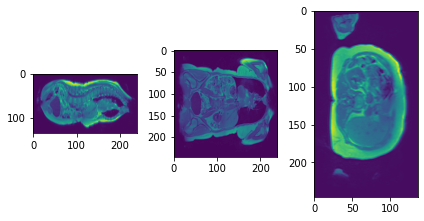

Affine:[[   2.            0.            0.         -221.3697629 ]
 [   0.            2.            0.         -172.96640778]
 [   0.            0.            3.         -688.65729654]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


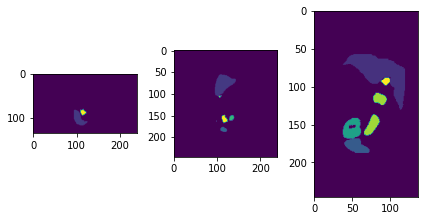

Saving Processed & Stitched Image.....
FINISHED.


In [29]:
volume = img_ras_sampled_combined
volume, stitched_label = label_stitching(img_ras_list[1:], volume)

mode='nearest'
stitched_label_a = resample_from_to(stitched_label, [volume.shape, volume.affine], mode=mode)
print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(volume))
volume_3_view_viewer(get_volume_data(stitched_label))

print('Saving Processed & Stitched Image.....')
save_volume(volume, 'kora_volume')
save_volume(stitched_label, 'kora_label')
print('FINISHED.')

STARTING KORA.
Reading Volumes.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         266.92883301]
 [  0.           0.          -1.69999695  97.33310699]
 [  0.          -1.70138884   0.          24.67601776]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
header <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 288 288 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.7013888 1.7013888 1.699997  0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max        

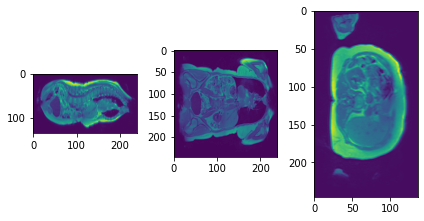

Saving Processed & Stitched Image.....
FINISHED.


In [25]:
print("STARTING KORA.")
print('Reading Volumes.....')
# file_to_read1 = './datasets/kora/KORA2452879/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz'
# file_to_read2 = './datasets/kora/KORA2452879/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'

file_to_read1 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz'
file_to_read2 = './datasets/kora/KORA2460249/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz'

img1_ras = read_ras(file_to_read1)
img2_ras = read_ras(file_to_read2)

print('Merging/Stitching Images.....')
img_ras_sampled_combined = multi_vol_stitching([img1_ras, img2_ras])

print('Viewing Stitched Images.....')
volume_3_view_viewer(get_volume_data(img_ras_sampled_combined))

print('Saving Processed & Stitched Image.....')
save_volume(img_ras_sampled_combined, 'kora_opp_volume')
print('FINISHED.')

In [26]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
label_files_to_read_list = glob.glob('./datasets/kora/KORA2452879_label/**')

img_ras_list = []
volume = img_ras_sampled_combined
for label_file_to_read in label_files_to_read_list:
    img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
    print(img_ras.shape, label_file_to_read, lidx, labelname)
    mode='nearest'
    img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
#     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine], mode=mode)
    
    print(img_ras.shape)
    img_ras_list.append([img_ras, lidx, labelname])

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
Reading Files.....
Reading NRRD Files.....
header <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 288 288 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.        1.7013888 1.699997  1.7013888 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.70710677
quatern_c

(246, 137, 164)
Reading Files.....
Reading NRRD Files.....
header <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 288 288 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.        1.7013888 1.699997  1.7013888 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.70710677
quatern_c       : -0.0
quatern_d       : -0

In [ ]:
print("STARTING UKB.")
print('Reading Volumes.....')
file_to_read1 = './datasets/kora/KORA2452879/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'

_, _, img = file_reader(file_to_read1)
print(img.header)
# img1_ras = read_raw(file_to_read1)

In [ ]:
hdr = img.header
qb, qc, qd = hdr['quatern_b'], hdr['quatern_c'], hdr['quatern_d']

qa = np.sqrt(1 - qb**2 - qc**2 - qd**2)

print(1- qb**2 - qc**2 - qd**2, qa, qb, qc, qd)


In [ ]:
m00 = qa**2 + qb**2 - qc**2 - qd**2
m01 = 2*(qb*qc - qa*qd)
m02 = 2*(qb*qd + qa*qc)

m10 = 2*(qb*qc + qa*qd)
m11 = qa**2 + qc**2 - qb**2 - qd**2
m12 = 2*(qc*qd - qa*qb)

m20 = 2*(qb*qd - qa*qc)
m21 = 2*(qc*qd + qa*qb)
m22 = qa**2 + qd**2 - qb**2 - qc**2

R = np.array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])

R

In [ ]:
Q = 1 if hdr['pixdim'][0]>=1 else hdr['pixdim'][0]

Q



In [ ]:
data = img.get_fdata()

data.shape

In [ ]:
np.dot(R, data)

In [ ]:
I, J, K = data.shape

pixdims = np.array(hdr['pixdim'][1:4])
qoffsets =  np.array([hdr['qoffset_x'], hdr['qoffset_y'], hdr['qoffset_z']])
print(pixdims, qoffsets)

world_data = None#np.empty_like(data)


for i in range(I):
    for j in range(J):
        for k in range(K):
            print(i,j,k, data[i, j, k])
            if world_data is None:
                X, Y, Z = np.abs(np.round(np.multiply(np.dot(R, data.shape),pixdims) + qoffsets)).astype('int32')
                world_data = np.empty((X+1, Y+1, Z+1))
            x, y, z = np.abs(np.round(np.multiply(np.dot(R, [i, j, k]),pixdims) + qoffsets)).astype('int32')
            print(x,y,z)
            world_data[x,y,z] = data[i, j, k]
            
            

In [ ]:
volume_img = nb.Nifti1Image(world_data, img.affine,img.header)
save_volume(volume_img, 'kora_volume_sform')

In [ ]:
np.dot(R, [100, 140, 80])


In [ ]:
np.multiply(np.dot(R, [100, 140, 80]),pixdims)

In [ ]:
np.multiply(np.dot(R, [100, 140, 80]),pixdims)+np.array([1,2,3])

In [ ]:
datax = data
x, y, z = np.round(np.multiply(np.dot(R, [280, 280, 160]),pixdims)+np.array([1,2,3]))
print(x, y, z)
world_data[x,y,z] = data[i, j, k]

In [ ]:
o = np.multiply(np.dot( data[100, 140, 80], R),pixdims)+np.array([1,2,3])

In [ ]:
o.shape